In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("reddit").getOrCreate()

In [2]:
from pyspark.sql.functions import col, udf, lit, concat, lower

In [3]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType, IntegerType, BooleanType, MapType

sub_schema = StructType()\
    .add("id", StringType(), True)\
    .add("title", StringType(), True)\
    .add("url", StringType(), True)\
    .add("author", StringType(), True)\
    .add("score", StringType(), True)\
    .add("subreddit", StringType(), True)\
    .add("created_utc", StringType(), True)


com_schema = StructType()\
    .add("id", StringType(), True)\
    .add("author", StringType(), True)\
    .add("link_id", StringType(), True)\
    .add("parent_id", StringType(), True)\
    .add("body", StringType(), True)\
    .add("subreddit", StringType(), True)\
    .add("created_utc", StringType(), True)\
    .add("score", StringType(), True)

In [4]:
comments = spark.read.schema(com_schema).json("comment.json")

In [5]:
comments.count()

4261614

In [6]:
comments.show()

+-------+------------+--------+----------+--------------------+---------+-----------+-----+
|     id|      author| link_id| parent_id|                body|subreddit|created_utc|score|
+-------+------------+--------+----------+--------------------+---------+-----------+-----+
|c03furo|    nerdlife|t3_6a2bf|  t3_6a2bf|Im not going to d...|      Art| 1205457635|    2|
|c03grjc|   [deleted]|t3_6cawp|  t3_6cawp|           [deleted]|      Art| 1205757437|    1|
|c03h6ll|   [deleted]|t3_6cj6c|  t3_6cj6c|           [deleted]|      Art| 1205862588|    1|
|c03h768|   [deleted]|t3_6a2bf|t1_c03furo|          I agree...|      Art| 1205864955|    1|
|c03h794|      OMouse|t3_6cjdw|  t3_6cjdw|Post your art som...|      Art| 1205865252|    3|
|c03hd6h|dsg123456789|t3_6cjdw|  t3_6cjdw|It would help if ...|      Art| 1205899588|    1|
|c03hj50|   [deleted]|t3_6cjdw|t1_c03hd6h|Thanks, I'll do f...|      Art| 1205949552|    1|
|c03hj5u|   [deleted]|t3_6cjdw|t1_c03h794|      Working on it.|      Art| 120594

In [7]:
# df = comments.filter(col("author") != "[deleted]")

In [8]:
df = comments.filter(col("link_id") == col("parent_id")).cache()

In [9]:
df.show()

+-------+------------+--------+---------+--------------------+---------+-----------+-----+
|     id|      author| link_id|parent_id|                body|subreddit|created_utc|score|
+-------+------------+--------+---------+--------------------+---------+-----------+-----+
|c03furo|    nerdlife|t3_6a2bf| t3_6a2bf|Im not going to d...|      Art| 1205457635|    2|
|c03grjc|   [deleted]|t3_6cawp| t3_6cawp|           [deleted]|      Art| 1205757437|    1|
|c03h6ll|   [deleted]|t3_6cj6c| t3_6cj6c|           [deleted]|      Art| 1205862588|    1|
|c03h794|      OMouse|t3_6cjdw| t3_6cjdw|Post your art som...|      Art| 1205865252|    3|
|c03hd6h|dsg123456789|t3_6cjdw| t3_6cjdw|It would help if ...|      Art| 1205899588|    1|
|c03hjzh|      OMouse|t3_6copr| t3_6copr|What's really nic...|      Art| 1205954100|    1|
|c03hkdv|   kickstand|t3_6cosf| t3_6cosf|I knew a Lucia on...|      Art| 1205956082|    2|
|c03ij9g|      OMouse|t3_6d1ql| t3_6d1ql|We need more subm...|      Art| 1206236946|    2|

In [10]:
df.count()

2666694

In [11]:
df2 = df.filter(col("author") != "AutoModerator").cache()

In [12]:
df3 = df2.filter(col("author") != "art_moderator_bot").cache() 

In [13]:
df3 = df3.filter(col("body") != "[deleted]")

In [14]:
df3.count()

2115742

In [19]:
df3.coalesce(1).write.json("comments_clean")

In [19]:
df3.groupby("author").count().agg({'count': 'avg'}).show()

+------------------+
|        avg(count)|
+------------------+
|3.1610273695282234|
+------------------+



In [27]:
!pip install matplotlib

     |████████████████████████████████| 10.3 MB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 81.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 28.7 MB/s eta 0:00:01


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt


In [52]:
# Show histogram of the 'C1' column
pddf = df3.groupby("author").count().toPandas()

# This is a bit awkward but I believe this is the correct way to do it 
# plt.hist(bins=bins, weights=counts)


In [65]:
pddf.size

1338642

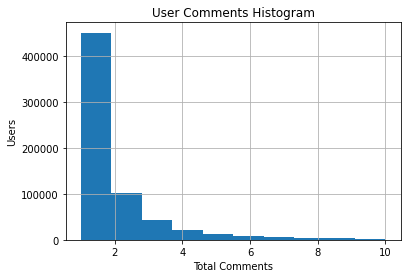

In [76]:
axarr = pddf.hist(range=[1, 10], )

for ax in axarr.flatten():
    ax.set_title("User Comments Histogram")
    ax.set_xlabel("Total Comments")
    ax.set_ylabel("Users")

In [35]:
df3.groupby("author").count().select('count').show()

+-----+
|count|
+-----+
|   22|
|    2|
|   15|
|   12|
|    6|
|    1|
|    1|
|    2|
|    2|
|    1|
|    5|
|    6|
|    9|
|    1|
|    3|
|    1|
|    1|
|    3|
|    4|
|    8|
+-----+
only showing top 20 rows



In [21]:
df3.groupby("author").count().agg({'count': 'stddev'}).show()

+-----------------+
|    stddev(count)|
+-----------------+
|745.5366351271192|
+-----------------+



In [22]:
df3.groupby("link_id").count().agg({'count': 'stddev'}).show()

+-----------------+
|    stddev(count)|
+-----------------+
|19.80788826774562|
+-----------------+



In [23]:
df3.groupby("link_id").count().agg({'count': 'avg'}).show()

+-----------------+
|       avg(count)|
+-----------------+
|4.671801269666022|
+-----------------+



In [77]:
pddf = df3.groupby("link_id").count().toPandas()

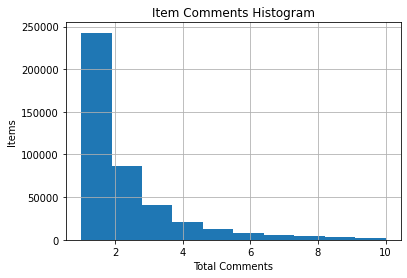

In [78]:
axarr = pddf.hist(range=[1, 10], )

for ax in axarr.flatten():
    ax.set_title("Item Comments Histogram")
    ax.set_xlabel("Total Comments")
    ax.set_ylabel("Items")

In [ ]:
.agg({'count': 'mean'}).show()

In [ ]:
df3.groupby("author").count().agg({'count': 'mean', 'count': 'stddev'}).show()

In [18]:
df3.groupby("author").count().sort("count", ascending=False).show()

+--------------------+-----+
|              author|count|
+--------------------+-----+
|        VerditerBlue|12928|
|         neodiogenes|10138|
| flair_your_post_bot| 5428|
|                w0ut| 3853|
|          ethan_kahn| 3549|
|   Deviantart-Mirror| 2985|
|               O-shi| 2940|
|   Respectfullyyours| 2010|
|         pHorniCaiTe| 1390|
|            magelanz| 1373|
|            powderdd| 1280|
|AnthropomorphizedHat| 1270|
|           beezabubs| 1051|
|    awkwardtheturtle|  972|
|  ToastWithTangerine|  941|
|              MrFack|  881|
|        Noimnotsally|  752|
|            kenJisoo|  707|
|        MusaibWadkar|  700|
|         IndexObject|  698|
+--------------------+-----+
only showing top 20 rows



In [102]:
tags = [
    'agreeableness',
    'anger',
    'anticipation',
    'arrogance',
    'disagreeableness',
    'disgust',
    'fear',
    'gratitude',
    'happiness',
    'humility',
    'love',
    'optimism',
    'pessimism',
    'regret',
    'sadness',
    'shame',
    'shyness',
    'surprise',
    'trust',
    'neutral',
    
    'happy',
    'sad',
    'lonely',
    'weird',
    'angry',
    'scary',
    'gloomy',
    'peaceful'
]

In [103]:
from pyspark.sql.types import StringType, ArrayType

def find_tags(text, tags):
    if text:
        return [t for t in tags if t in text]
    else:
        return []
    
find_tags_udf = udf(lambda z: find_tags(z, tags), ArrayType(StringType()))

In [104]:
df4 = df3.withColumn("body", lower("body")).withColumn("tags", find_tags_udf("body")).cache()

In [105]:
df4.show()

+-------+-------------+--------+---------+--------------------+---------+-----------+-----+-------+
|     id|       author| link_id|parent_id|                body|subreddit|created_utc|score|   tags|
+-------+-------------+--------+---------+--------------------+---------+-----------+-----+-------+
|c03furo|     nerdlife|t3_6a2bf| t3_6a2bf|im not going to d...|      Art| 1205457635|    2|     []|
|c03h794|       OMouse|t3_6cjdw| t3_6cjdw|post your art som...|      Art| 1205865252|    3|     []|
|c03hd6h| dsg123456789|t3_6cjdw| t3_6cjdw|it would help if ...|      Art| 1205899588|    1|     []|
|c03hjzh|       OMouse|t3_6copr| t3_6copr|what's really nic...|      Art| 1205954100|    1|     []|
|c03hkdv|    kickstand|t3_6cosf| t3_6cosf|i knew a lucia on...|      Art| 1205956082|    2|     []|
|c03ij9g|       OMouse|t3_6d1ql| t3_6d1ql|we need more subm...|      Art| 1206236946|    2|     []|
|c03iu7e|     nerdlife|t3_6d1wp| t3_6d1wp|yeh, andy kehoe r...|      Art| 1206347403|    1| [love]|


In [106]:
from pyspark.sql.functions import length, size

In [107]:
df5 = df4.filter(size(col("tags")) > 0).cache()

In [108]:
df5.count()

196236

In [109]:
from pyspark.sql.functions import explode
df6 = df5.withColumn("tag", explode("tags")).cache()

In [110]:
df6.show()

+-------+------------------+--------+---------+--------------------+---------+-----------+-----+---------+-------+
|     id|            author| link_id|parent_id|                body|subreddit|created_utc|score|     tags|    tag|
+-------+------------------+--------+---------+--------------------+---------+-----------+-----+---------+-------+
|c03iu7e|          nerdlife|t3_6d1wp| t3_6d1wp|yeh, andy kehoe r...|      Art| 1206347403|    1|   [love]|   love|
|c03jn3v|      nightbiscuit|t3_6dgm1| t3_6dgm1|some of my painti...|      Art| 1206548856|    7|  [trust]|  trust|
|c03jp27|     piratepanties|t3_6dgm1| t3_6dgm1|currently on a ma...|      Art| 1206556987|    3|   [love]|   love|
|c03jqwz|            xxeyes|t3_6dgm1| t3_6dgm1|i'm not really an...|      Art| 1206564170|    3|   [love]|   love|
|c03jvw5|     InstantIndian|t3_6dgm1| t3_6dgm1|i am so happy the...|      Art| 1206594046|    4|  [happy]|  happy|
|c03kjf4|lazed_and_confused|t3_6drbl| t3_6drbl|i love how hippie...|      Art| 1

In [111]:
df6.groupby("tag").count().sort("count", ascending=False).show()

+------------+------+
|         tag| count|
+------------+------+
|        love|161809|
|       happy|  8996|
|       weird|  7247|
|         sad|  7040|
|       anger|  2846|
|    surprise|  2331|
|        fear|  1939|
|       scary|  1904|
|       shame|  1844|
|    peaceful|  1571|
|       trust|  1029|
|       angry|  1009|
|     disgust|   943|
|      lonely|   686|
|     sadness|   635|
|      regret|   602|
|   happiness|   559|
|     neutral|   363|
|      gloomy|   128|
|anticipation|    82|
+------------+------+
only showing top 20 rows



In [112]:
from pyspark.sql.functions import  collect_list

In [113]:
df7 = df6.groupby("link_id").agg(collect_list("tag")).withColumn("n_tags", size(col("collect_list(tag)")))

In [114]:
df7.sort("n_tags", ascending=False).show()

+---------+--------------------+------+
|  link_id|   collect_list(tag)|n_tags|
+---------+--------------------+------+
|t3_39fthj|[love, love, love...|   167|
|t3_cmw9ek|[love, love, weir...|   143|
|t3_6393x4|[love, shame, lov...|   118|
|t3_gjjcap|[love, love, love...|   116|
|t3_gqd2p0|[love, love, love...|   110|
|t3_auq433|[love, love, love...|   108|
|t3_d0ezsm|[love, love, peac...|   103|
|t3_3cagpf|[happy, love, lov...|   102|
|t3_df0qid|[love, love, love...|    99|
|t3_dr8uaq|[love, love, love...|    90|
|t3_bjkaht|[fear, weird, lov...|    88|
|t3_azgs1n|[peaceful, love, ...|    86|
|t3_38u5f9|[happiness, happy...|    83|
|t3_do8kl4|[love, sad, love,...|    82|
|t3_jg9r4c|[love, love, love...|    81|
|t3_7pplrd|[peaceful, happin...|    79|
|t3_7s54bw|[trust, surprise,...|    77|
|t3_j5sdu9|[love, happy, lov...|    77|
|t3_4bcnql|[love, love, angr...|    75|
|t3_k16bzk|[love, love, happ...|    75|
+---------+--------------------+------+
only showing top 20 rows



In [115]:
from collections import Counter

def count_tags(tags):
    return dict(Counter(tags))
    
count_tags_udf = udf(lambda z: count_tags(z), MapType(StringType(), IntegerType()))

In [116]:
df8 = df7.withColumn("tag_counts", count_tags_udf(col("collect_list(tag)")))

In [117]:
df8.sort("n_tags", ascending=False).show()

+---------+--------------------+------+--------------------+
|  link_id|   collect_list(tag)|n_tags|          tag_counts|
+---------+--------------------+------+--------------------+
|t3_39fthj|[love, love, love...|   167|[trust -> 1, love...|
|t3_cmw9ek|[love, love, weir...|   143|[love -> 126, sur...|
|t3_6393x4|[love, shame, lov...|   118|[trust -> 1, love...|
|t3_gjjcap|[love, love, love...|   116|[love -> 99, surp...|
|t3_gqd2p0|[love, love, love...|   110|[love -> 100, sur...|
|t3_auq433|[love, love, love...|   108|[love -> 89, surp...|
|t3_d0ezsm|[love, love, peac...|   103|[love -> 85, weir...|
|t3_3cagpf|[happy, love, lov...|   102|[love -> 68, weir...|
|t3_df0qid|[love, love, love...|    99|[love -> 93, happ...|
|t3_dr8uaq|[love, love, love...|    90|[love -> 76, weir...|
|t3_bjkaht|[fear, weird, lov...|    88|[trust -> 1, love...|
|t3_azgs1n|[peaceful, love, ...|    86|[love -> 63, weir...|
|t3_38u5f9|[happiness, happy...|    83|[trust -> 1, love...|
|t3_do8kl4|[love, sad, l

In [24]:
submissions = spark.read.schema(sub_schema).json("submission.json")

In [25]:
submissions.count()

1466539

In [68]:
submissions.groupby("author").count().agg({'count': 'stddev'}).show()

+------------------+
|     stddev(count)|
+------------------+
|252.50164876831025|
+------------------+



In [42]:
submissions = submissions.withColumn("t3_id", concat(lit("t3_"), col("id")))

In [33]:
submissions.show()

+-----+--------------------+--------------------+-------------+-----+---------+-----------+--------+
|   id|               title|                 url|       author|score|subreddit|created_utc|   t3_id|
+-----+--------------------+--------------------+-------------+-----+---------+-----------+--------+
|66nud|Very funky Art si...|http://www.artswh...|  Thumperings|    7|      Art| 1201321706|t3_66nud|
|66u0g|Inka Essenhigh - ...|http://www.inka-e...|    [deleted]|    3|      Art| 1201507917|t3_66u0g|
|66udm|Adi Granov is bet...|http://www.adigra...|    [deleted]|    1|      Art| 1201518531|t3_66udm|
|66xjq|Illustration :: I...|http://www.illust...|    [deleted]|    3|      Art| 1201574128|t3_66xjq|
|682ke|      Erotic Massage|http://www.pics-n...|      picmium|    0|      Art| 1202464784|t3_682ke|
|68lf0|Universal DRM war...|http://files.myop...|    demonstro|    0|      Art| 1202901064|t3_68lf0|
|699mw|Online Picasso Pr...|http://picasso.cs...| hulahulagirl|    1|      Art| 1203444455|

In [121]:
joined = df8.join(submissions, df8.link_id == submissions.t3_id , "inner")

In [122]:
joined.select(["url", "tag_counts", "link_id"]).show()

+--------------------+--------------------+--------+
|                 url|          tag_counts| link_id|
+--------------------+--------------------+--------+
|http://www.andyke...|         [love -> 1]|t3_6d1wp|
|https://www.reddi...|[love -> 2, trust...|t3_6dgm1|
|http://centennial...|         [love -> 1]|t3_6drbl|
|http://en.wikiped...|      [disgust -> 1]|t3_6hl7e|
|http://news.bbc.c...|         [love -> 1]|t3_6jfgk|
|http://fcmx.net/v...|         [love -> 1]|t3_6k0au|
|http://www.brookl...|         [love -> 1]|t3_6l4no|
|http://entertainm...|        [angry -> 1]|t3_6lcuk|
|http://www.sfgate...|         [love -> 1]|t3_6nemu|
|http://www.nytime...|         [love -> 1]|t3_6nh61|
|http://gallery.ra...|         [love -> 1]|t3_6nhjr|
|http://www.alexey...|         [love -> 1]|t3_6nmbc|
|http://i-seldom-d...|         [love -> 1]|t3_6o49n|
|http://www.design...|         [love -> 1]|t3_6o4xk|
|http://www.tat2ts...|        [shame -> 1]|t3_6oic1|
|http://blogs.guar...|         [love -> 1]|t3_

In [123]:
# joined.select(["url", "tag_counts", "link_id"]).coalesce(1).write.mode("overwrite").json("image_tags.json")

In [124]:
joined.count()

87335

In [125]:
image_exist = spark.read.json("exist.json")

In [126]:
image_exist = spark.read.json("exist.json")

In [127]:
image_exist.show(10, False)

+--------+-----------------------------------------------------------------------------------+
|id      |url                                                                                |
+--------+-----------------------------------------------------------------------------------+
|t3_6rlvi|http://www.swoyersart.com/andrew_wyeth/christinasworld.jpg                         |
|t3_9k85p|http://imgur.com/IEVK2.jpg                                                         |
|t3_9zifh|http://i578.photobucket.com/albums/ss229/paulzeke/bucky_tat_final.jpg              |
|t3_annss|http://imgur.com/QHkaf.jpg                                                         |
|t3_b7ngn|http://imgur.com/iSFSx.jpg                                                         |
|t3_bm54v|http://imgur.com/jo6Mm.jpg                                                         |
|t3_bq316|http://i.imgur.com/f8qov.jpg                                                       |
|t3_bxk0t|http://www.nn.ru/data/ufiles/4/00/69/100

In [128]:
# final_dataset = image_exist.join(joined, joined.link_id == image_exist.id , "inner")

In [143]:
# final_dataset = final_dataset.select([image_exist.id, "author", "score", "tag_counts", "title", "created_utc", image_exist.url])

In [144]:
final_dataset = joined

In [145]:
final_dataset.show()

+---------+--------------------+------+--------------------+------+--------------------+--------------------+--------------------+-----+---------+-----------+---------+
|  link_id|   collect_list(tag)|n_tags|          tag_counts|    id|               title|                 url|              author|score|subreddit|created_utc|    t3_id|
+---------+--------------------+------+--------------------+------+--------------------+--------------------+--------------------+-----+---------+-----------+---------+
|t3_10gub6|              [love]|     1|         [love -> 1]|10gub6|"Ambient Love" Wh...|http://imgur.com/...|                Du7s|   27|      Art| 1348603615|t3_10gub6|
|t3_10qhd2|             [weird]|     1|        [weird -> 1]|10qhd2|r/art, I need you...|http://i.imgur.co...|    TitusAndroidicus|   10|      Art| 1349050699|t3_10qhd2|
|t3_13s2ce|[love, love, love...|     6|[love -> 5, weird...|13s2ce|Birth, Oils on ca...|http://i.imgur.co...|               Bean0| 1130|      Art| 13538826

In [146]:
final_dataset.count()

87335

In [132]:
final_dataset.coalesce(1).write.json("rart-v0.5")

In [147]:
data = final_dataset.toPandas().to_dict("records")

In [148]:
data[0]

{'link_id': 't3_10gub6',
 'collect_list(tag)': ['love'],
 'n_tags': 1,
 'tag_counts': {'love': 1},
 'id': '10gub6',
 'title': '"Ambient Love" White charcoal on black strathmore paper.  Dimensions 19 in x 9 in (48.26 cm x 22.86 cm)  About 8 hours',
 'url': 'http://imgur.com/a/PGOg1',
 'author': 'Du7s',
 'score': '27',
 'subreddit': 'Art',
 'created_utc': '1348603615',
 't3_id': 't3_10gub6'}

In [149]:
max_score = max([int(item["score"]) for item in data])

In [150]:
min_score = min([int(item["score"]) for item in data])

In [151]:
min_score, max_score

(0, 98754)

In [154]:
from collections import defaultdict, Counter

tags = defaultdict(list)

for item in data:
    id = item.get("id")
    score = int(item["score"])
    factor = score / max_score
    extension = item.get("url").split(".")[-1]
    file = f"imagefiles/{id}.{extension}"
    for tag, count in item.get("tag_counts", {}).items():
        tags[tag].append((item.get("url"), count))

for tag in tags:
    tags[tag] = sorted(tags[tag], key=lambda x: -x[1])[0:100]

In [155]:
import pickle
pickle.dump(tags, open("tags.p", "wb"))

In [156]:
tags.keys()

dict_keys(['love', 'weird', 'happy', 'sad', 'shame', 'happiness', 'fear', 'gloomy', 'neutral', 'anger', 'scary', 'lonely', 'sadness', 'trust', 'surprise', 'disgust', 'angry', 'peaceful', 'pessimism', 'regret', 'anticipation', 'gratitude', 'optimism', 'humility', 'arrogance', 'shyness'])

In [157]:
tags["happy"]

[('http://imgur.com/5ZR7Y2q', 45),
 ('http://i.imgur.com/a1UTAoG.jpg?1.jpg', 34),
 ('https://i.redd.it/z93syy4oruxy.jpg', 24),
 ('https://i.redd.it/r1rlxlg9hcr51.jpg', 24),
 ('https://i.redd.it/o4oku48qk9py.png', 23),
 ('http://imgur.com/Mf09Fou', 22),
 ('https://i.redd.it/yao3wukokpry.jpg', 19),
 ('https://i.redd.it/2anz79rxg7n01.jpg', 16),
 ('http://imgur.com/9twwzjA', 14),
 ('https://i.redd.it/ztzjqonmthm11.jpg', 14),
 ('https://i.imgur.com/HVTzfFm.jpg', 14),
 ('https://medium.com/@noahbradley/how-i-became-an-artist-4390c6b6656c', 14),
 ('http://www.birthdaywishessms.com/birthday-wishes/birthday-wishes/', 14),
 ('https://i.redd.it/rvcfbmltf5841.jpg', 14),
 ('https://i.redd.it/10z3puo01si21.jpg', 13),
 ('https://i.redd.it/mzwlzi8me9tz.jpg', 13),
 ('http://imgur.com/gallery/ypyya', 12),
 ('https://i.redd.it/xvmoo08ziul51.jpg', 12),
 ('http://i.imgur.com/Qa9Paax.jpg', 12),
 ('https://i.redd.it/pw0n37qm0f841.jpg', 12),
 ('http://imgur.com/81Yigef', 11),
 ('https://i.redd.it/jhpechlmnfn3

In [121]:
from flask import Flask

import pickle

app = Flask(__name__)

tags = pickle.load(open("tags.p", "rb"))

@app.route('/show/<tag>', methods=['GET'])
def show(tag): 
    images = tags.get(tag)
    elements = [f"<img src={url}/>" for url, count in images]
    return "<br/>".join(elements)

if __name__ == "__main__":
    app.debug = True
    app.run(host='0.0.0.0', port=5000)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


OSError: [Errno 98] Address already in use

In [116]:
!pip3 install flask

     |████████████████████████████████| 94 kB 5.2 MB/s  eta 0:00:01
     |████████████████████████████████| 298 kB 26.4 MB/s eta 0:00:01


In [48]:
 from io import StringIO

In [66]:
url = "http://www.likecool.com/Gear/Other/Spider-Man%20Tattoo/Spider-Man-Tattoo.jpg"

In [74]:
r = requests.get(url, stream=True)
r.status_code in list(range(200, 210))

False

In [72]:
list(range(200, 210))

[200, 201, 202, 203, 204, 205, 206, 207, 208, 209]

In [5]:
import mimetypes
import requests

def is_url_image(url):    
    mimetype,encoding = mimetypes.guess_type(url)
    return (mimetype and mimetype.startswith('image'))

def url_exists(url):
    try:
        r = requests.get(url, timeout=0.001)
        return r.status_code in list(range(200, 210))
    except:
        return False
    
def check_image(url):
    return is_url_image(url)

In [6]:
is_image_udf = udf(lambda z: is_url_image(z), BooleanType())

In [7]:
url_exists_udf = udf(lambda z: url_exists(z), BooleanType())

In [38]:
submissions = spark.read.schema(sub_schema).json("submission.json")

In [9]:
submissions = submissions.filter(is_image_udf(col("url")))

In [10]:
submissions = submissions.filter(url_exists_udf(col("url")))

In [11]:
# submissions.show()

In [13]:
spark.stop()

In [12]:
submissions.write.json("images_exist.json")

KeyboardInterrupt: 

In [22]:
submissions.select(["url"]).show(10, False)

+------------------------------------------------------------------------------------------------------+
|url                                                                                                   |
+------------------------------------------------------------------------------------------------------+
|http://files.myopera.com/Demonstro/files/noDRM.jpg                                                    |
|http://a803.ac-images.myspacecdn.com/images01/104/l_15ff23446023db13c0ee26664f8a6012.jpg              |
|http://www.bruno9li.com/imagens/desenhos/desenhos/avant-19.jpg                                        |
|http://www.notcot.com/images/Teddy-Fetal-Development.jpg                                              |
|http://www.drawing-studio.net/drawings.php?show=9&amp;pic=chopperdrawing.jpg                          |
|http://www.foundshit.com/images/stacked-chairs-06.jpg                                                 |
|http://www.banksy.co.uk/shop/images/shop%20large/stopa

In [12]:
submissions.count()

733903

In [14]:
submissions.write.json("images.json")

In [12]:
submissions = submissions.withColumn("image_exists", check_image_udf("url"))

In [17]:
submissions.select(["url", "image_exists"]).show(10, False)

+-----------------------------------------------------------+------------+
|url                                                        |image_exists|
+-----------------------------------------------------------+------------+
|http://www.artswhore.com/                                  |null        |
|http://www.inka-essenhigh.com/work.php?year=2005           |null        |
|http://www.adigranov.net/                                  |null        |
|http://www.illustrationmundo.com/                          |null        |
|http://www.pics-nsfw.com/erotic_massage.htm                |false       |
|http://files.myopera.com/Demonstro/files/noDRM.jpg         |true        |
|http://picasso.csdl.tamu.edu/picasso/                      |null        |
|http://www.msnbc.msn.com/id/23226815/                      |null        |
|http://www.newsweek.com/id/114505                          |null        |
|http://www.pics-nsfw.com/sara_jean_playmate_of_the_year.htm|false       |
+------------------------

In [11]:
# submissions = submissionsDF.filter(col("author") != "[deleted]")

In [12]:
submissions = submissions.where(check_image_udf("url"))

In [ ]:
submissions.show()

In [1]:
import pandas as pd

In [ ]:
df = pd.read_json("submission.json", orient="records", lines=True, chunksize=5)

In [ ]:
df.head

In [11]:
!pip3 install zope.event

In [3]:
!pip3 install jsonlines

In [1]:
!pip3 install grequests

     |████████████████████████████████| 6.1 MB 10.5 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 16.3 MB/s eta 0:00:01


In [ ]:
import jsonlines

In [ ]:
import grequests

In [ ]:
from itertools import chain, islice

In [ ]:
def sub_gen():
    with jsonlines.open('submission.json') as reader:
        for obj in reader:
            yield obj

In [ ]:
def chunks(iterable, size=10):
    iterator = iter(iterable)
    for first in iterator:
        yield chain([first], islice(iterator, size - 1))

In [23]:
import time
from tqdm import tqdm

data =  tqdm(sub_gen(), total=1373590)

with jsonlines.open("images.json", mode='w') as writer:
    for batch in chunks(data, 10000):
        ids = (sub.get("id") for sub in batch)
        rs = (requests.get(sub.get("url"), timeout=5) for sub in batch)
        requests = grequests.map(rs)
        results = zip(ids, requests)
        for id, r in results:
            if r.status_code == 200:
                r.raw.decode_content = True
                writer.write({"id": id, "raw": r})
            response.close()
    


  1%|          | 8866/1373590 [00:18<01:32, 14716.57it/s]Traceback (most recent call last):
  File "src/gevent/greenlet.py", line 854, in gevent._gevent_cgreenlet.Greenlet.run
  File "/home/stathis/.local/lib/python3.8/site-packages/grequests.py", line 74, in send
    self.response = self.session.request(self.method,
  File "/usr/lib/python3/dist-packages/requests/sessions.py", line 533, in request
    resp = self.send(prep, **send_kwargs)
  File "/usr/lib/python3/dist-packages/requests/sessions.py", line 668, in send
    history = [resp for resp in gen] if allow_redirects else []
  File "/usr/lib/python3/dist-packages/requests/sessions.py", line 668, in <listcomp>
    history = [resp for resp in gen] if allow_redirects else []
  File "/usr/lib/python3/dist-packages/requests/sessions.py", line 239, in resolve_redirects
    resp = self.send(
  File "/usr/lib/python3/dist-packages/requests/sessions.py", line 646, in send
    r = adapter.send(request, **kwargs)
  File "/usr/lib/python3/d

KeyboardInterrupt: 

In [36]:
from pyspark.sql.types import StringType, ArrayType, FloatType


In [37]:
emot_schema = StructType()\
    .add("id", StringType(), True)\
    .add("emotion_vec", ArrayType(FloatType()), True)

In [38]:
emotions = spark.read.schema(emot_schema).json("comment_emotions.json")

In [39]:
emotions.show()

+-------+--------------------+
|     id|         emotion_vec|
+-------+--------------------+
|c03furo|[0.0497812, 0.152...|
|c03h794|[0.023478767, 0.2...|
|c03hd6h|[0.4753953, 7.780...|
|c03hjzh|[0.4188293, 9.928...|
|c03hkdv|[0.0057698945, 0....|
|c03ij9g|[0.0905313, 0.094...|
|c03imvr|[0.12965919, 0.02...|
|c03iu7e|[0.56050825, 0.00...|
|c03iw7i|[0.016138373, 0.0...|
|c03izrd|[0.75507784, 5.70...|
|c03izs2|[0.070797615, 4.2...|
|c03j9w2|[0.54097486, 6.23...|
|c03jkuj|[0.73603946, 0.01...|
|c03jmlt|[0.115270786, 0.0...|
|c03jmqe|[0.076493636, 0.1...|
|c03jmwz|[0.021115225, 7.8...|
|c03jn0q|[0.20216453, 0.01...|
|c03jn3v|[0.2870943, 0.004...|
|c03jnaa|[0.14683734, 2.49...|
|c03jnab|[0.21548876, 0.00...|
+-------+--------------------+
only showing top 20 rows



In [46]:
# import numpy as np

def threshold(emotion_vec, t=0.5):
    return max(emotion_vec) > t
    
threshold_udf = udf(lambda z: threshold(z), BooleanType())

In [49]:
emotions = emotions.filter(threshold_udf("emotion_vec"))

In [50]:
emotions.show()

+-------+--------------------+------+
|     id|         emotion_vec|over_t|
+-------+--------------------+------+
|c03hd6h|[0.4753953, 7.780...|  true|
|c03hjzh|[0.4188293, 9.928...|  true|
|c03hkdv|[0.0057698945, 0....|  true|
|c03ij9g|[0.0905313, 0.094...|  true|
|c03imvr|[0.12965919, 0.02...|  true|
|c03iu7e|[0.56050825, 0.00...|  true|
|c03iw7i|[0.016138373, 0.0...|  true|
|c03izrd|[0.75507784, 5.70...|  true|
|c03izs2|[0.070797615, 4.2...|  true|
|c03j9w2|[0.54097486, 6.23...|  true|
|c03jkuj|[0.73603946, 0.01...|  true|
|c03jmlt|[0.115270786, 0.0...|  true|
|c03jmwz|[0.021115225, 7.8...|  true|
|c03jn0q|[0.20216453, 0.01...|  true|
|c03jnaa|[0.14683734, 2.49...|  true|
|c03jnab|[0.21548876, 0.00...|  true|
|c03jnxv|[0.14211048, 0.00...|  true|
|c03jo21|[0.016262192, 0.0...|  true|
|c03jo2d|[0.06832139, 6.54...|  true|
|c03joac|[0.1989255, 0.010...|  true|
+-------+--------------------+------+
only showing top 20 rows



In [51]:
emotions.count()

960708

In [52]:
comments_with_emotions = df3.join(emotions, emotions.id == df3.id , "inner")

In [53]:
comments_with_emotions.show()

+-------+--------------+--------+---------+--------------------+---------+-----------+-----+-------+--------------------+------+
|     id|        author| link_id|parent_id|                body|subreddit|created_utc|score|     id|         emotion_vec|over_t|
+-------+--------------+--------+---------+--------------------+---------+-----------+-----+-------+--------------------+------+
|c06b0op|       xenmate|t3_7co9l| t3_7co9l|I met the guy who...|      Art| 1226428250|    4|c06b0op|[0.17572966, 0.00...|  true|
|c06lz2b|  netzwerkerin|t3_7go7v| t3_7go7v|Beautiful. I espe...|      Art| 1228165923|    1|c06lz2b|[0.91883814, 0.00...|  true|
|c06s7vo| davy_crockett|t3_7ivhe| t3_7ivhe|         Beautiful.
|      Art| 1229050460|    2|c06s7vo|[0.7037442, 2.713...|  true|
|c06tug5|       McCourt|t3_7jd0m| t3_7jd0m|I made some art o...|      Art| 1229313173|    1|c06tug5|[0.090898536, 0.0...|  true|
|c06u6gf|    toastspork|t3_7jmxf| t3_7jmxf|Yeah, but does he...|      Art| 1229368496|    2|c06u6

In [54]:
# comments_with_emotions.filter()

TypeError: filter() missing 1 required positional argument: 'condition'

In [55]:
from pyspark.sql.functions import  collect_list, struct

In [56]:
sub_emotions = comments_with_emotions.groupby("link_id").agg(collect_list(struct("emotion_vec", "score" )).alias('emotion_vectors'))

In [57]:
sub_emotions.show()

+---------+--------------------+
|  link_id|     emotion_vectors|
+---------+--------------------+
|t3_102aax|[[[0.083767965, 0...|
|t3_10gub6|[[[0.3919034, 0.0...|
|t3_10qhd2|[[[0.020172872, 4...|
|t3_10ty9j|[[[0.0675569, 2.6...|
|t3_10y64t|[[[0.027583351, 0...|
|t3_111zxi|[[[0.9299609, 0.0...|
|t3_11230w|[[[0.77947307, 9....|
|t3_11are5|[[[0.010591315, 0...|
|t3_11odq4|[[[0.1371927, 0.0...|
|t3_1218z6|[[[0.010698277, 0...|
|t3_128d69|[[[0.010603078, 0...|
|t3_12j87i|[[[0.21066576, 6....|
|t3_12rxlk|[[[0.89184487, 5....|
|t3_132oct|[[[0.028816408, 0...|
|t3_13o6su|[[[0.6286757, 0.0...|
|t3_13s2ce|[[[0.6388502, 7.9...|
|t3_145iy8|[[[0.004785503, 0...|
|t3_154oac|[[[0.25290874, 0....|
|t3_15srbd|[[[0.016758537, 0...|
|t3_1673vf|[[[0.7542311, 0.0...|
+---------+--------------------+
only showing top 20 rows



In [58]:
from pyspark.sql.functions import col, udf, lit, concat, lower

In [59]:
import numpy as np
import logging 

from pyspark.sql.types import StringType, ArrayType

def aggregate_emotions(emotions):
    weights = np.asarray([w for vec, w in emotions if int(w) > 0]).astype(np.float32)
    vectors = np.asarray([vec for vec, w in emotions if int(w) > 0]).astype(np.float32)
    try: 
        return np.average(vectors, weights=weights, axis=0).tolist()
    except ZeroDivisionError:
        return 0
    
aggregate_emotions_udf = udf(lambda z: aggregate_emotions(z), ArrayType(FloatType()))

In [60]:
aggregated_sub_emotions = sub_emotions.withColumn("aggregated_emotion", aggregate_emotions_udf("emotion_vectors"))

In [61]:
aggregated_sub_emotions.show()

+---------+--------------------+--------------------+
|  link_id|     emotion_vectors|  aggregated_emotion|
+---------+--------------------+--------------------+
|t3_102aax|[[[0.083767965, 0...|[0.083767965, 0.0...|
|t3_10gub6|[[[0.3919034, 0.0...|[0.20777953, 0.01...|
|t3_10qhd2|[[[0.020172872, 4...|[0.5544765, 0.001...|
|t3_10ty9j|[[[0.0675569, 2.6...|[0.07209065, 2.81...|
|t3_10y64t|[[[0.027583351, 0...|[0.027583351, 0.0...|
|t3_111zxi|[[[0.9299609, 0.0...|[0.6057731, 0.005...|
|t3_11230w|[[[0.77947307, 9....|[0.77947307, 9.28...|
|t3_11are5|[[[0.010591315, 0...|[0.29680663, 0.01...|
|t3_11odq4|[[[0.1371927, 0.0...|[0.1371927, 0.003...|
|t3_1218z6|[[[0.010698277, 0...|[0.010698277, 0.0...|
|t3_128d69|[[[0.010603078, 0...|[0.010603078, 0.0...|
|t3_12j87i|[[[0.21066576, 6....|[0.21066576, 6.93...|
|t3_12rxlk|[[[0.89184487, 5....|[0.89184487, 5.70...|
|t3_132oct|[[[0.028816408, 0...|[0.016773887, 0.0...|
|t3_13o6su|[[[0.6286757, 0.0...|[0.6286757, 0.001...|
|t3_13s2ce|[[[0.6388502, 7.9

In [62]:
final = aggregated_sub_emotions.select("link_id", "aggregated_emotion")

In [64]:
final.count()

267497

In [63]:
final.repartition(1).write.json("submission_emotions_t_0.5")

In [33]:
sub_emot_schema = StructType()\
    .add("link_id", StringType(), True)\
    .add("aggregated_emotion", ArrayType(FloatType()), True)

In [34]:
sub_emotions = spark.read.schema(sub_emot_schema).json("submission_emotions.json")

In [35]:
sub_emotions.show()

+---------+--------------------+
|  link_id|  aggregated_emotion|
+---------+--------------------+
|t3_102aax|[0.17384443, 0.02...|
|t3_10gub6|[0.20777953, 0.01...|
|t3_10qhd2|[0.5098521, 0.005...|
|t3_10ty9j|[0.07209065, 2.81...|
|t3_10y64t|[0.027583351, 0.0...|
|t3_111zxi|[0.24036725, 0.13...|
|t3_11230w|[0.63590133, 0.00...|
|t3_11are5|[0.29680663, 0.01...|
|t3_11odq4|[0.1371927, 0.003...|
|t3_1218z6|[0.010698277, 0.0...|
|t3_121age|[0.03815273, 0.04...|
|t3_128d69|[0.010603078, 0.0...|
|t3_12j87i|[0.21066576, 6.93...|
|t3_12ru2t|[0.25520676, 0.00...|
|t3_12rxlk|[0.89184487, 5.70...|
|t3_132oct|[0.049937755, 0.0...|
|t3_136902|[0.4657143, 0.005...|
|t3_13o6su|[0.6286757, 0.001...|
|t3_13s2ce|[0.22349279, 0.01...|
|t3_145iy8|[0.01888282, 0.02...|
+---------+--------------------+
only showing top 20 rows



In [36]:
sub_emotions.count()

423504

In [43]:
sub_emotions = sub_emotions.join(submissions, sub_emotions.link_id == submissions.t3_id , "inner")

In [44]:
sub_emotions.show()

+---------+--------------------+------+--------------------+--------------------+----------------+-----+---------+-----------+---------+
|  link_id|  aggregated_emotion|    id|               title|                 url|          author|score|subreddit|created_utc|    t3_id|
+---------+--------------------+------+--------------------+--------------------+----------------+-----+---------+-----------+---------+
|t3_102aax|[0.17384443, 0.02...|102aax|Untitled, varying...|http://imgur.com/...|     mobocrat707|    1|      Art| 1347941446|t3_102aax|
|t3_10gub6|[0.20777953, 0.01...|10gub6|"Ambient Love" Wh...|http://imgur.com/...|            Du7s|   27|      Art| 1348603615|t3_10gub6|
|t3_10qhd2|[0.5098521, 0.005...|10qhd2|r/art, I need you...|http://i.imgur.co...|TitusAndroidicus|   10|      Art| 1349050699|t3_10qhd2|
|t3_10ty9j|[0.07209065, 2.81...|10ty9j|Hey guys, where c...|http://www.reddit...|       [deleted]|    2|      Art| 1349205777|t3_10ty9j|
|t3_10y64t|[0.027583351, 0.0...|10y64t|Bu

In [45]:
sub_emotions_list = sub_emotions.collect()

In [49]:
sub_emotions_list[0].asDict() 

{'link_id': 't3_102aax',
 'aggregated_emotion': [0.17384442687034607,
  0.02685193158686161,
  0.026561951264739037,
  0.015882741659879684,
  0.0549689382314682,
  0.0005345718236640096,
  0.040291573852300644,
  0.006422464270144701,
  0.6541600227355957,
  0.00016786629566922784,
  9.53915441641584e-05,
  0.00014389140415005386,
  7.41473922971636e-05],
 'id': '102aax',
 'title': 'Untitled, varying sizes, Spray paint on canvas. Critiques please.',
 'url': 'http://imgur.com/a/xlVvK',
 'author': 'mobocrat707',
 'score': '1',
 'subreddit': 'Art',
 'created_utc': '1347941446',
 't3_id': 't3_102aax'}